# SpeedUp

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# Function to load and preprocess data
def load_and_preprocess_data(filename, max_harmonics):
    df = pd.read_csv(filename)
    
    # Clean columns
    df['TotalTime_ms'] = pd.to_numeric(df['TotalTime_ms'], errors='coerce')
    df['Speedup'] = pd.to_numeric(df['Speedup'], errors='coerce')
    df['Efficiency'] = pd.to_numeric(df['Efficiency'], errors='coerce')
    df['Threads'] = pd.to_numeric(df['Threads'], errors='coerce')
    
    # Filter by max_harmonics
    df = df[df['Harmonics'] <= max_harmonics]
    
    # Calculate Overhead, Amdahl’s Fraction, Gustafson’s Scaled Speedup
    df['Overhead_ms'] = np.nan
    df['Amdahls_Fraction'] = np.nan
    df['Gustafsons_Scaled_Speedup'] = np.nan
    
    for idx, row in df.iterrows():
        if row['Algorithm'].startswith('Holmes') and row['Threads'] > 1:
            holmes1_row = df[(df['Algorithm'] == 'Holmes1') & (df['Harmonics'] == row['Harmonics'])]
            if not holmes1_row.empty:
                T_s = holmes1_row['TotalTime_ms'].iloc[0]
                T_p = row['TotalTime_ms']
                p = row['Threads']
                df.at[idx, 'Overhead_ms'] = T_p * p - T_s
                S_p = row['Speedup']
                if S_p >= 1 and p > 1 and S_p > 0:
                    f = (p - S_p) / (S_p * (p - 1))
                    if 0 <= f <= 1:
                        df.at[idx, 'Amdahls_Fraction'] = f
                        df.at[idx, 'Gustafsons_Scaled_Speedup'] = f + (1 - f) * p
    return df

# Define colors
def get_colors():
    return {
        'green': (100/255, 175/255, 135/255),
        'red': (222/255, 95/255, 100/255),
        'yellow': (250/255, 203/255, 105/255),
        'blue': (95/255, 183/255, 230/255),
        'violet': (165/255, 140/255, 190/255),
        'orange': (250/255, 157/255, 91/255),
        'teal': (64/255, 160/255, 160/255),
        'maroon': (160/255, 64/255, 64/255),
        'navy': (64/255, 64/255, 160/255),
        'black': (0/255, 0/255, 0/255),
        'light gray': (211/255, 211/255, 211/255),
        'gray': (128/255, 128/255, 128/255),
        'dark gray': (169/255, 169/255, 169/255)
    }

# Style plot function
def style_plot(ax, ylabel, xlabel='Number of Harmonics', fontprop_axis=None, fontprop_ticks=None, label_size=22):
    for spine in ax.spines.values():
        spine.set_alpha(0.3)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=label_size - 2)
    ax.set_xlabel(xlabel, fontproperties=fontprop_axis)
    ax.set_ylabel(ylabel, fontproperties=fontprop_axis)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.1, which='minor', axis='y')

# Annotation function
def add_annotations(ax, grouped_data, methods_list, method_colors, y_col, x_col='Harmonics', x_extend=50, 
                    text_offset_x=10.5, log_reserve=1, log_reserve_min=1, exp_base=10):
    points = []
    max_x = 0
    for method in methods_list:
        if method not in grouped_data or len(grouped_data[method]) == 0:
            continue
        tail_data = grouped_data[method][y_col].tail(100)
        avg_y = tail_data.mean()
        last_x = grouped_data[method][x_col].iloc[-1]
        last_y = grouped_data[method][y_col].iloc[-1]
        if pd.notna(avg_y) and pd.notna(last_y):
            points.append({'method': method, 'x': last_x, 'y': last_y, 'avg_y': avg_y, 'color': method_colors[method]})
            max_x = max(max_x, last_x)
    
    if not points:
        return
    
    points.sort(key=lambda p: p['avg_y'], reverse=True)
    current_xlim = ax.get_xlim()
    ax.set_xlim(current_xlim[0], max_x + x_extend)
    text_x = max_x + text_offset_x
    if len(points) > 1:
        log_ys = np.log10([p['y'] for p in points])
        min_log_y = min(log_ys) - log_reserve_min
        max_log_y = max(log_ys) + log_reserve
        log_text_ys = np.linspace(max_log_y, min_log_y, len(points))
        text_ys = exp_base ** log_text_ys
    else:
        text_ys = [points[0]['y'] * exp_base**0.1]
    
    for i, p in enumerate(points):
        text_y = text_ys[i]
        ax.annotate(p['method'], xy=(p['x'], p['y']), xytext=(text_x, text_y),
                    arrowprops=dict(arrowstyle='->', color=p['color'], lw=1.5, alpha=0.3),
                    fontsize=label_size - 4, fontproperties=fontprop_ticks,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=p['color'], alpha=0.3),
                    ha='left', va='center')

# Main plotting function
def plot_metrics(df, output_prefix, font_path_axis, font_path_ticks, label_size=22, 
                annotation_params=None, max_harmonics=None):
    # Font settings
    fontprop_axis = fm.FontProperties(fname=font_path_axis, size=label_size)
    fontprop_ticks = fm.FontProperties(fname=font_path_ticks, size=label_size - 2)
    
    # Colors and methods
    colors = get_colors()
    dashed_colors = ['teal', 'maroon', 'navy']
    all_methods = df['Algorithm'].unique()
    methods = [m for m in all_methods if not (m.startswith('Holmes') and int(m[6:]) >= 5 and int(m[6:]) % 2 == 1)]
    speedup_methods = [m for m in methods if m not in ['Belikov', 'Cunningham', 'Holmes1']]
    
    # Assign colors
    color_keys = list(colors.keys())
    method_colors = {}
    for i, method in enumerate(methods):
        color_key = color_keys[i % len(color_keys)]
        method_colors[method] = colors[color_key]
    holmes_methods = [m for m in methods if m.startswith('Holmes')]
    if holmes_methods:
        max_threads_method = max(holmes_methods, key=lambda m: int(m[6:]))
        method_colors[max_threads_method] = colors['black']
    
    # Default annotation parameters
    default_annotation_params = {
        'total_time': {'x_extend': 100, 'text_offset_x': 30, 'log_reserve': 4, 'exp_base': 2.2},
        'speedup': {'x_extend': 70, 'text_offset_x': 20.5, 'log_reserve': 3, 'exp_base': 1.6},
        'efficiency': {'x_extend': 70, 'text_offset_x': 20.5, 'log_reserve': 15.5, 'exp_base': 1.1}
    }
    if annotation_params is not None:
        for key in default_annotation_params:
            default_annotation_params[key].update(annotation_params.get(key, {}))
    
    # 1. Total Time Plot
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    grouped_data = {}
    for method in methods:
        method_df = df[df['Algorithm'] == method]
        grouped = method_df.groupby('Harmonics')['TotalTime_ms'].mean().reset_index()
        grouped_data[method] = grouped
        if len(grouped) > 0 and not grouped['TotalTime_ms'].isna().all():
            linestyle = '--' if method_colors[method] in [colors[c] for c in dashed_colors] and method != max_threads_method else '-'
            ax1.plot(grouped['Harmonics'], grouped['TotalTime_ms'], 
                     color=method_colors[method], linewidth=1.5, linestyle=linestyle)
    
    style_plot(ax1, 'Execution Time, ms', fontprop_axis=fontprop_axis, fontprop_ticks=fontprop_ticks)
    add_annotations(ax1, grouped_data, methods, method_colors, 'TotalTime_ms', **default_annotation_params['total_time'])
    plt.tight_layout()
    ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1] + 2)
    plt.savefig(f'{output_prefix}_total_time_vs_harmonics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Speedup Plot
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    grouped_speedup_data = {}
    for method in speedup_methods:
        method_df = df[df['Algorithm'] == method]
        grouped = method_df.groupby('Harmonics')['Speedup'].mean().reset_index()
        grouped_speedup_data[method] = grouped
        if len(grouped) > 0 and not grouped['Speedup'].isna().all():
            linestyle = '--' if method_colors[method] in [colors[c] for c in dashed_colors] and method != max_threads_method else '-'
            ax2.plot(grouped['Harmonics'], grouped['Speedup'], 
                     color=method_colors[method], linewidth=1.5, linestyle=linestyle)
    
    style_plot(ax2, 'Speedup', fontprop_axis=fontprop_axis, fontprop_ticks=fontprop_ticks)
    add_annotations(ax2, grouped_speedup_data, speedup_methods, method_colors, 'Speedup', **default_annotation_params['speedup'])
    plt.tight_layout()
    ax2.set_xlim(ax2.get_xlim()[0], ax2.get_xlim()[1] + 2)
    plt.savefig(f'{output_prefix}_speedup_vs_harmonics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Efficiency Plot
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    grouped_efficiency_data = {}
    for method in speedup_methods:
        method_df = df[df['Algorithm'] == method]
        grouped = method_df.groupby('Harmonics')['Efficiency'].mean().reset_index()
        grouped_efficiency_data[method] = grouped
        if len(grouped) > 0 and not grouped['Efficiency'].isna().all():
            linestyle = '--' if method_colors[method] in [colors[c] for c in dashed_colors] and method != max_threads_method else '-'
            ax3.plot(grouped['Harmonics'], grouped['Efficiency'], 
                     color=method_colors[method], linewidth=1.5, linestyle=linestyle)
    
    style_plot(ax3, 'Efficiency', fontprop_axis=fontprop_axis, fontprop_ticks=fontprop_ticks)
    add_annotations(ax3, grouped_efficiency_data, speedup_methods, method_colors, 'Efficiency', **default_annotation_params['efficiency'])
    plt.tight_layout()
    ax3.set_xlim(ax3.get_xlim()[0], ax3.get_xlim()[1] + 2)
    plt.savefig(f'{output_prefix}_efficiency_vs_harmonics.png', dpi=300, bbox_inches='tight')
    plt.show()



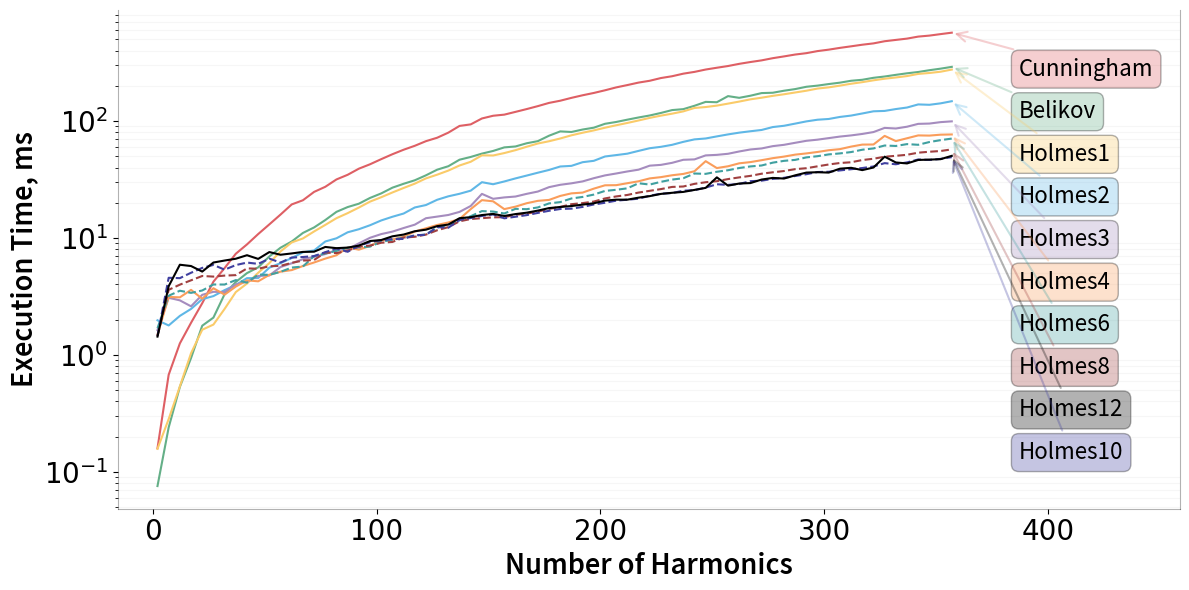

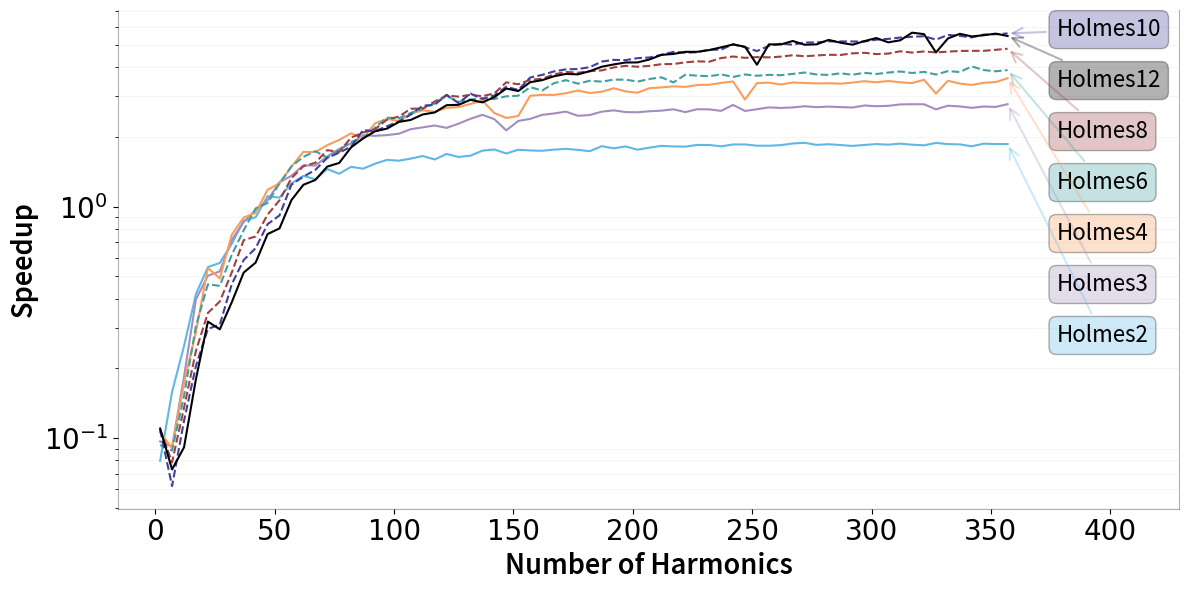

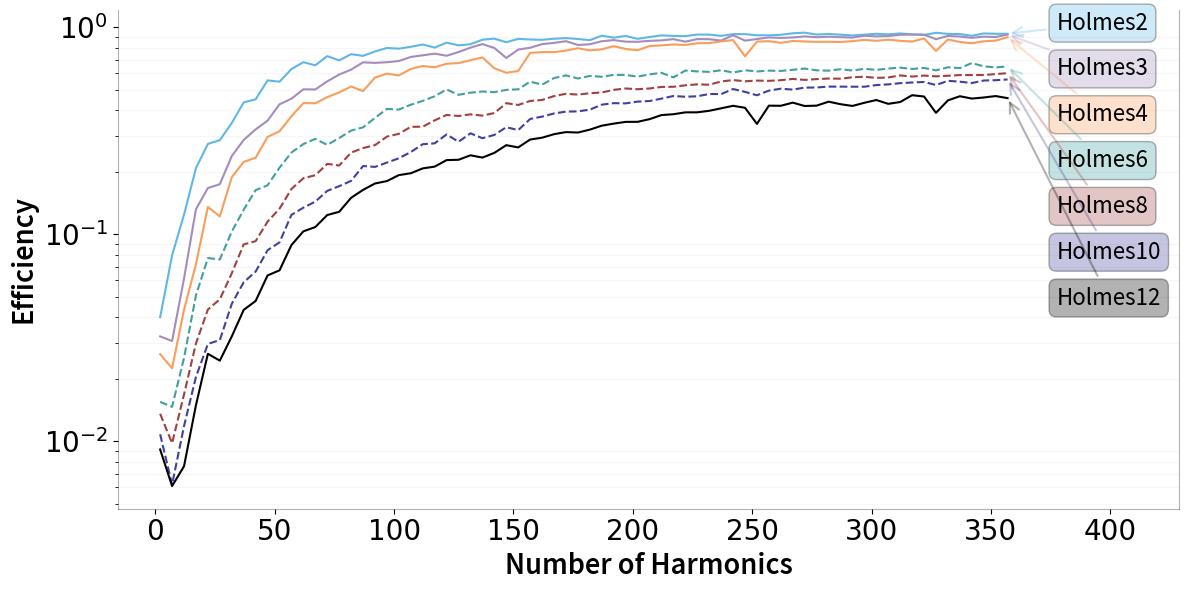

In [109]:
# Configuration and execution cell
def main():
    # Configuration parameters
    config = {
        'filename': 'proc/benchmark_AMD_Ryzen_5_7600X_6-Core_Processor_12_100.csv',
        'max_harmonics': 360,
        'font_path_axis': 'e:/Documents/fonts/SourceSansPro-SemiBold.ttf',
        'font_path_ticks': 'e:/Documents/fonts/SourceSansPro-Regular.otf',
        'label_size': 22,
        'output_prefix': 'plot',
        'annotation_params': {
            'total_time': {'x_extend': 100, 'text_offset_x': 30, 'log_reserve': 4, 'log_reserve_min': 4, 'exp_base': 2.3},
            'speedup': {'x_extend': 70, 'text_offset_x': 20.5, 'log_reserve': 3, 'log_reserve_min': 3, 'exp_base': 1.6},
            'efficiency': {'x_extend': 70, 'text_offset_x': 20.5, 'log_reserve': 0.1,'log_reserve_min': 4,  'exp_base': 2}
        }
    }
    
    # Load and preprocess data
    df = load_and_preprocess_data(config['filename'], config['max_harmonics'])
    
    # Plot metrics
    plot_metrics(
        df=df,
        output_prefix=config['output_prefix'],
        font_path_axis=config['font_path_axis'],
        font_path_ticks=config['font_path_ticks'],
        label_size=config['label_size'],
        annotation_params=config['annotation_params'],
        max_harmonics=config['max_harmonics']
    )

if __name__ == '__main__':
    main()

# Tables

In [43]:
def generate_latex_table(df, metric, harmonics, processor_labels, caption, label, output_dir):
    if df is None or df.empty:
        logging.error(f"Cannot generate table {label}: Dataframe is empty or None.")
        return None
    
    # Filter harmonics that exist in data
    available_harmonics = df['Harmonics'].unique()
    harmonics = [h for h in harmonics if h in available_harmonics]
    if not harmonics:
        logging.error(f"No requested harmonics {harmonics} found in data: {available_harmonics}")
        return None
    
    # Filter processors that exist in data
    processors = [p for p in processor_labels.keys() if p in df['Processor'].unique()]
    if not processors:
        logging.error(f"No matching processors found in data for {processor_labels.keys()}")
        return None
    
    # Prepare table data
    threads = sorted(df['Threads'].unique())
    table_data = {}
    for n in harmonics:
        table_data[n] = {}
        for processor in processors:
            table_data[n][processor] = {}
            for t in threads:
                algorithm = f"Holmes{t}"
                data = df[(df['Algorithm'] == algorithm) & (df['Harmonics'] == n) & (df['Processor'] == processor)][metric]
                value = data.mean() if not data.empty else np.nan
                table_data[n][processor][t] = value
                if data.empty:
                    logging.warning(f"No data for Algorithm={algorithm}, Harmonics={n}, Processor={processor}")
    
    # LaTeX table generation
    latex = r"""
\begin{table*}[ht]
\centering
\caption{""" + caption + r"""}
\label{""" + label + r"""}
\begin{tabular}{c|""" + "|".join(["c" * len(processors) for _ in harmonics]) + r"""}
\hline
 & """ + " & ".join([f"\\multicolumn{{{len(processors)}}}{{c}}{{\\textbf{{n={n}}}}} " for n in harmonics]) + r""" \\
\cline{2-7}
{\textbf{Threads}}
& """ + " & ".join([f"\\textbf{{{processor_labels[p]}}}" for n in harmonics for p in processors]) + r""" \\
\hline
"""
    for t in threads:
        row = [f"\\textbf{{{int(t)}}}"]  # Жирный шрифт для номеров потоков
        for n in harmonics:
            for p in processors:
                value = table_data[n][p].get(t, np.nan)
                if np.isnan(value):
                    row.append("-")
                else:
                    row.append(f"{value:.3f}")
        latex += " & ".join(row) + r" \\ \hline" + "\n"
    
    latex += r"""
\end{tabular}
\end{table*}
"""
    # Save to file
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, f"{label.replace(':', '_')}.tex")
    try:
        with open(filename, 'w') as f:
            f.write(latex)
        logging.info(f"Generated table: {filename}")
        return filename
    except Exception as e:
        logging.error(f"Error writing table {label}: {str(e)}")
        return None
    
def generate_processor_decoding_table(processor_descriptions, output_dir):
    latex = r"""
\begin{table}[ht]
\centering
\caption{Processor label decoding}
\label{tab:processor_decoding}
\begin{tabular}{l|l}
\hline
\textbf{Label} & \textbf{Processor Description} \\
\hline
"""
    for label, desc in processor_descriptions.items():
        latex += f"\\textbf{{{label}}} & {desc} \\\\ \\hline\n"
    
    latex += r"""
\end{tabular}
\end{table}
"""
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, "processor_decoding.tex")
    try:
        with open(filename, 'w') as f:
            f.write(latex)
        logging.info(f"Generated processor decoding table: {filename}")
        return filename
    except Exception as e:
        logging.error(f"Error writing processor decoding table: {str(e)}")
        return None

In [45]:
import pandas as pd
import numpy as np
import os
import glob
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_and_preprocess_data(filenames):
    dfs = []
    for filename in filenames:
        try:
            # Extract processor name (everything before the last two underscores: _threads_100)
            base_name = os.path.basename(filename).replace('benchmark_', '').rsplit('_', 2)[0]
            logging.info(f"Processing file: {filename}, Processor: {base_name}")
            df = pd.read_csv(filename)
            
            # Verify required columns
            required_columns = ['Algorithm', 'Harmonics', 'Threads', 'TotalTime_ms', 'Speedup', 'Efficiency']
            if not all(col in df.columns for col in required_columns):
                logging.error(f"Missing required columns in {filename}: {required_columns}")
                continue
            
            # Clean columns
            df['TotalTime_ms'] = pd.to_numeric(df['TotalTime_ms'], errors='coerce')
            df['Speedup'] = pd.to_numeric(df['Speedup'], errors='coerce')
            df['Efficiency'] = pd.to_numeric(df['Efficiency'], errors='coerce')
            df['Threads'] = pd.to_numeric(df['Threads'], errors='coerce')
            
            # Calculate Overhead
            df['Overhead_ms'] = np.nan
            for idx, row in df.iterrows():
                if row['Algorithm'].startswith('Holmes') and row['Threads'] > 1:
                    holmes1_row = df[(df['Algorithm'] == 'Holmes1') & (df['Harmonics'] == row['Harmonics'])]
                    if not holmes1_row.empty:
                        T_s = holmes1_row['TotalTime_ms'].iloc[0]
                        T_p = row['TotalTime_ms']
                        p = row['Threads']
                        df.at[idx, 'Overhead_ms'] = T_p * p - T_s
                    else:
                        logging.warning(f"No Holmes1 data for Harmonics={row['Harmonics']} in {filename}")
            
            df['Processor'] = base_name
            dfs.append(df)
        except Exception as e:
            logging.error(f"Error processing {filename}: {str(e)}")
    
    if not dfs:
        logging.error("No dataframes loaded. Check CSV files and their contents.")
        return None
    
    # Combine dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df = combined_df[combined_df['Algorithm'].str.startswith('Holmes') & (combined_df['Algorithm'] != 'Holmes1')]
    
    if combined_df.empty:
        logging.error("No data after filtering for Holmes algorithms (excluding Holmes1).")
        return None
    
    logging.info(f"Loaded data with {len(combined_df)} rows after filtering.")
    logging.info(f"Unique Algorithms: {combined_df['Algorithm'].unique()}")
    logging.info(f"Unique Harmonics: {combined_df['Harmonics'].unique()}")
    logging.info(f"Unique Threads: {combined_df['Threads'].unique()}")
    logging.info(f"Unique Processors: {combined_df['Processor'].unique()}")
    return combined_df



def main():
    # Configuration parameters
    config = {
        'input_dir': 'proc',
        'harmonics': [52, 357],  # Updated to match your table
        'output_dir': 'latex_tables',
        'tables': [
            {
                'metric': 'Speedup',
                'caption': 'Speedup for Holmes algorithms across different processors and harmonic numbers.',
                'label': 'tab:speedup_metrics'
            },
            {
                'metric': 'Efficiency',
                'caption': 'Efficiency for Holmes algorithms across different processors and harmonic numbers.',
                'label': 'tab:efficiency_metrics'
            },
            {
                'metric': 'Overhead_ms',
                'caption': 'Overhead (ms) for Holmes algorithms across different processors and harmonic numbers.',
                'label': 'tab:overhead_metrics'
            }
        ],
        'processor_descriptions': {
            'P4T8': 'Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz, 4 Cores, 8 Threads',
            'P6T12': 'AMD Ryzen 5 7600X, 6 Cores, 12 Threads',
            'P8T16': 'AMD Ryzen 7 PRO 3700, 8 Cores, 16 Threads'
        },
        'processor_mapping': {
            'Intel(R)_Core(TM)_i7-7820HQ_CPU_@_2.90GHz': 'P4T8',
            'AMD_Ryzen_5_7600X_6-Core_Processor': 'P6T12',
            'AMD_Ryzen_7_PRO_3700': 'P8T16'
        }
    }
    
    # Find all CSV files
    filenames = glob.glob(os.path.join(config['input_dir'], 'benchmark*.csv'))
    if not filenames:
        logging.error(f"No CSV files found in {config['input_dir']}")
        return
    
    logging.info(f"Found {len(filenames)} CSV files: {filenames}")
    
    # Generate processor labels
    processor_labels = config['processor_mapping']
    
    # Load and preprocess data
    df = load_and_preprocess_data(filenames)
    if df is None:
        logging.error("Failed to load or preprocess data. Exiting.")
        return
    
    # Generate processor decoding table
    generate_processor_decoding_table(config['processor_descriptions'], config['output_dir'])
    
    # Generate metric tables
    for table_config in config['tables']:
        generate_latex_table(
            df=df,
            metric=table_config['metric'],
            harmonics=config['harmonics'],
            processor_labels=processor_labels,
            caption=table_config['caption'],
            label=table_config['label'],
            output_dir=config['output_dir']
        )

if __name__ == '__main__':
    main()

2025-10-23 16:28:56,287 - INFO - Found 3 CSV files: ['proc\\benchmark_AMD_Ryzen_5_7600X_6-Core_Processor_12_100.csv', 'proc\\benchmark_AMD_Ryzen_7_PRO_3700_16_100.csv', 'proc\\benchmark_Intel(R)_Core(TM)_i7-7820HQ_CPU_@_2.90GHz_8_100.csv']
2025-10-23 16:28:56,287 - INFO - Processing file: proc\benchmark_AMD_Ryzen_5_7600X_6-Core_Processor_12_100.csv, Processor: AMD_Ryzen_5_7600X_6-Core_Processor
2025-10-23 16:28:56,483 - INFO - Processing file: proc\benchmark_AMD_Ryzen_7_PRO_3700_16_100.csv, Processor: AMD_Ryzen_7_PRO_3700
2025-10-23 16:28:58,533 - INFO - Processing file: proc\benchmark_Intel(R)_Core(TM)_i7-7820HQ_CPU_@_2.90GHz_8_100.csv, Processor: Intel(R)_Core(TM)_i7-7820HQ_CPU_@_2.90GHz
2025-10-23 16:28:58,658 - INFO - Loaded data with 6681 rows after filtering.
2025-10-23 16:28:58,659 - INFO - Unique Algorithms: ['Holmes2' 'Holmes3' 'Holmes4' 'Holmes5' 'Holmes6' 'Holmes7' 'Holmes8'
 'Holmes9' 'Holmes10' 'Holmes11' 'Holmes12' 'Holmes13' 'Holmes14'
 'Holmes15' 'Holmes16']
2025-10-23 

2025-10-23 16:28:58,772 - WARNING - No data for Algorithm=Holmes13, Harmonics=357, Processor=Intel(R)_Core(TM)_i7-7820HQ_CPU_@_2.90GHz
2025-10-23 16:28:58,773 - WARNING - No data for Algorithm=Holmes14, Harmonics=357, Processor=Intel(R)_Core(TM)_i7-7820HQ_CPU_@_2.90GHz
2025-10-23 16:28:58,774 - WARNING - No data for Algorithm=Holmes15, Harmonics=357, Processor=Intel(R)_Core(TM)_i7-7820HQ_CPU_@_2.90GHz
2025-10-23 16:28:58,775 - WARNING - No data for Algorithm=Holmes16, Harmonics=357, Processor=Intel(R)_Core(TM)_i7-7820HQ_CPU_@_2.90GHz
2025-10-23 16:28:58,783 - WARNING - No data for Algorithm=Holmes13, Harmonics=357, Processor=AMD_Ryzen_5_7600X_6-Core_Processor
2025-10-23 16:28:58,784 - WARNING - No data for Algorithm=Holmes14, Harmonics=357, Processor=AMD_Ryzen_5_7600X_6-Core_Processor
2025-10-23 16:28:58,785 - WARNING - No data for Algorithm=Holmes15, Harmonics=357, Processor=AMD_Ryzen_5_7600X_6-Core_Processor
2025-10-23 16:28:58,786 - WARNING - No data for Algorithm=Holmes16, Harmonic

## REAl

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np


# Цвета
colors = {
    'green': (100/255, 175/255, 135/255),
    'red': (222/255, 95/255, 100/255),
    'yellow': (250/255, 203/255, 105/255),
    'blue': (95/255, 183/255, 230/255),
    'violet': (165/255, 140/255, 190/255),
    'orange': (250/255, 157/255, 91/255),
    'teal': (64/255, 160/255, 160/255),
    'maroon': (160/255, 64/255, 64/255),
    'navy': (64/255, 64/255, 160/255),
    'black': (0/255, 0/255, 0/255)
}
dashed_colors = ['teal', 'maroon', 'navy']

# Настройки шрифтов
label_size = 22
font_path_axis = 'e:/Documents/fonts/SourceSansPro-SemiBold.ttf'
font_path_ticks = 'e:/Documents/fonts/SourceSansPro-Regular.otf'
fontprop_axis = fm.FontProperties(fname=font_path_axis, size=label_size)
fontprop_ticks = fm.FontProperties(fname=font_path_ticks, size=label_size - 2)

# Функция для настройки стиля графика (логарифмический масштаб)
def style_plot_log(ax, ylabel, xlabel='Number of Harmonics'):
    for spine in ax.spines.values():
        spine.set_alpha(0.3)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=label_size - 2)
    ax.set_xlabel(xlabel, fontproperties=fontprop_axis)
    ax.set_ylabel(ylabel, fontproperties=fontprop_axis)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.1, which='minor', axis='y')

# Функция для настройки стиля графика (линейный масштаб)
def style_plot_linear(ax, ylabel, xlabel='Number of Harmonics'):
    for spine in ax.spines.values():
        spine.set_alpha(0.3)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=label_size - 2)
    ax.set_xlabel(xlabel, fontproperties=fontprop_axis)
    ax.set_ylabel(ylabel, fontproperties=fontprop_axis)
    ax.grid(True, alpha=0.1)

# Функция для добавления аннотаций (логарифмический масштаб)
def add_annotations_log(ax, grouped_data, methods_list, method_colors, y_col, x_col='Harmonics', x_extend=50, text_offset_x=10.5, log_reserve=1, exp_base=10):
    points = []
    max_x = 0
    for method in methods_list:
        if method not in grouped_data or len(grouped_data[method]) == 0:
            continue
        tail_data = grouped_data[method][y_col].tail(100)
        avg_y = tail_data.mean()
        last_x = grouped_data[method][x_col].iloc[-1]
        last_y = grouped_data[method][y_col].iloc[-1]
        if pd.notna(avg_y) and pd.notna(last_y):
            points.append({'method': method, 'x': last_x, 'y': last_y, 'avg_y': avg_y, 'color': method_colors[method]})
            max_x = max(max_x, last_x)
    
    if not points:
        return
    
    points.sort(key=lambda p: p['avg_y'], reverse=True)
    current_xlim = ax.get_xlim()
    new_xlim = (current_xlim[0], max_x + x_extend)
    ax.set_xlim(new_xlim)
    text_x = max_x + text_offset_x
    if len(points) > 1:
        log_ys = np.log10([p['y'] for p in points])
        min_log_y = min(log_ys) - log_reserve
        max_log_y = max(log_ys) + log_reserve
        log_text_ys = np.linspace(max_log_y, min_log_y, len(points))
        text_ys = exp_base ** log_text_ys
    else:
        text_ys = [points[0]['y'] * exp_base**0.1]
    
    for i, p in enumerate(points):
        text_y = text_ys[i]
        ax.annotate(p['method'], xy=(p['x'], p['y']), xytext=(text_x, text_y),
                    arrowprops=dict(arrowstyle='->', color=p['color'], lw=1.5, alpha=0.3),
                    fontsize=label_size - 4, fontproperties=fontprop_ticks,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=p['color'], alpha=0.3),
                    ha='left', va='center')

# Функция для добавления аннотаций (линейный масштаб)
def add_annotations_linear(ax, grouped_data, methods_list, method_colors, y_col, x_col='Harmonics', x_extend=50, text_offset_x=10.5, y_extend=0.1):
    points = []
    max_x = 0
    for method in methods_list:
        if method not in grouped_data or len(grouped_data[method]) == 0:
            continue
        tail_data = grouped_data[method][y_col].tail(100)
        avg_y = tail_data.mean()
        last_x = grouped_data[method][x_col].iloc[-1]
        last_y = grouped_data[method][y_col].iloc[-1]
        if pd.notna(avg_y) and pd.notna(last_y):
            points.append({'method': method, 'x': last_x, 'y': last_y, 'avg_y': avg_y, 'color': method_colors[method]})
            max_x = max(max_x, last_x)
    
    if not points:
        return
    
    points.sort(key=lambda p: p['avg_y'], reverse=True)
    current_xlim = ax.get_xlim()
    new_xlim = (current_xlim[0], max_x + x_extend)
    ax.set_xlim(new_xlim)
    text_x = max_x + text_offset_x
    if len(points) > 1:
        ys = [p['y'] for p in points]
        min_y = min(ys) - y_extend * (max(ys) - min(ys))
        max_y = max(ys) + y_extend * (max(ys) - min(ys))
        text_ys = np.linspace(max_y, min_y, len(points))
    else:
        text_ys = [points[0]['y'] * (1 + y_extend)]
    
    for i, p in enumerate(points):
        text_y = text_ys[i]
        ax.annotate(p['method'], xy=(p['x'], p['y']), xytext=(text_x, text_y),
                    arrowprops=dict(arrowstyle='->', color=p['color'], lw=1.5, alpha=0.3),
                    fontsize=label_size - 4, fontproperties=fontprop_ticks,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=p['color'], alpha=0.3),
                    ha='left', va='center')


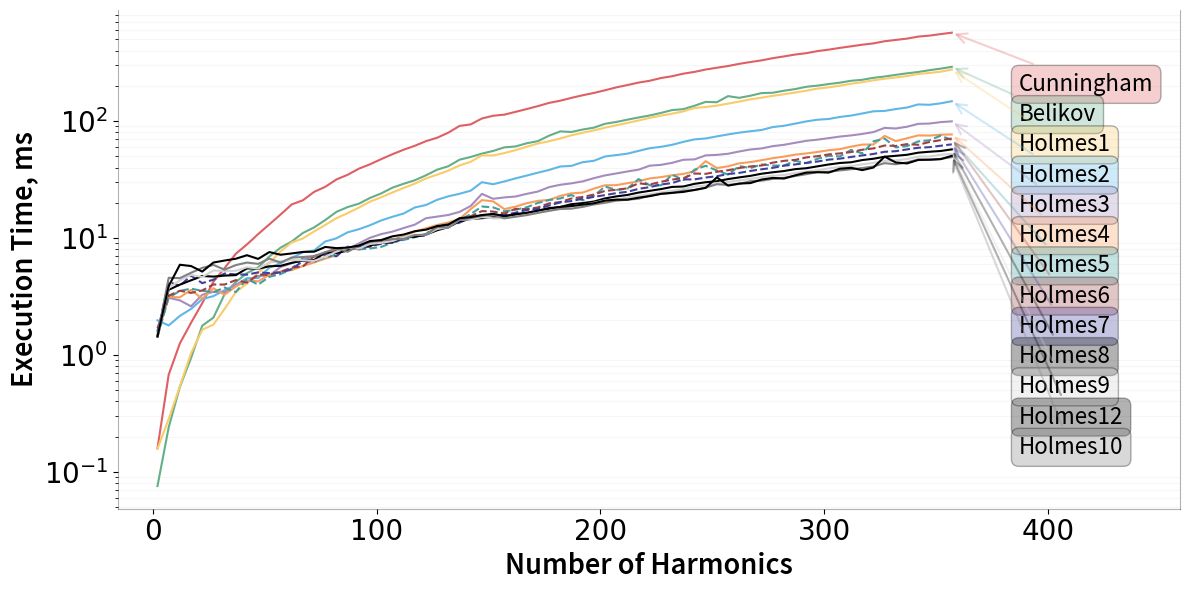

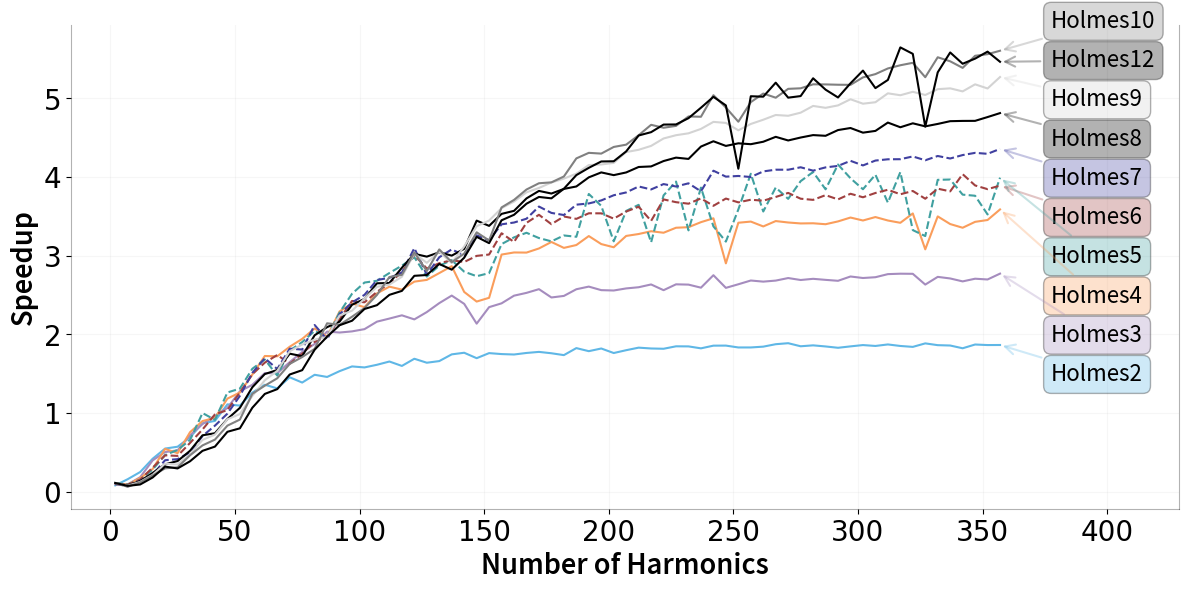

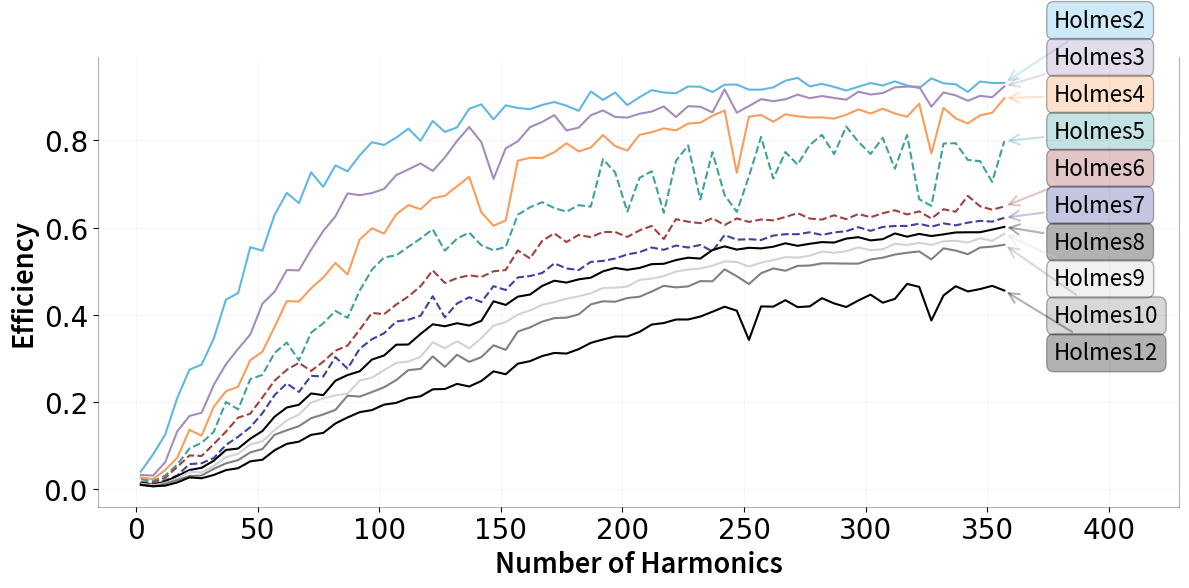

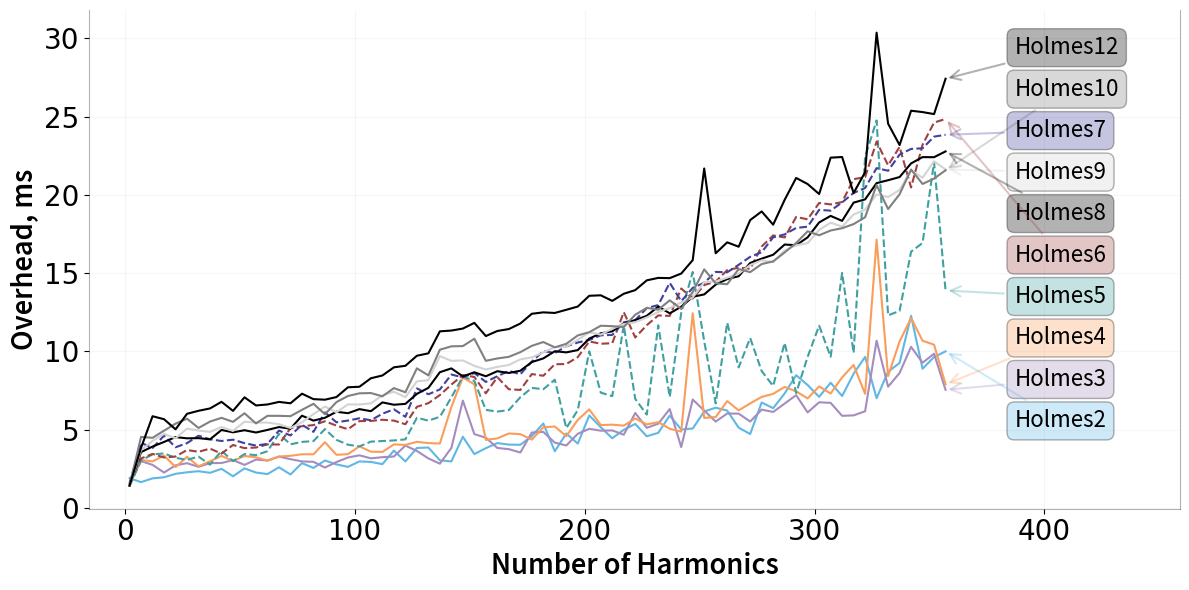

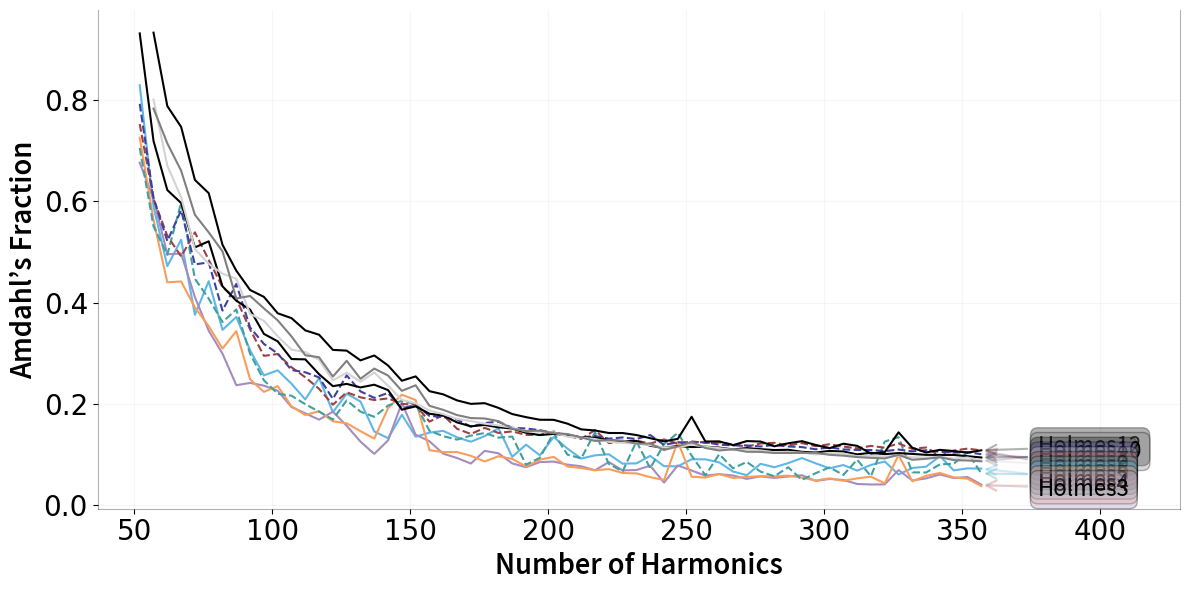

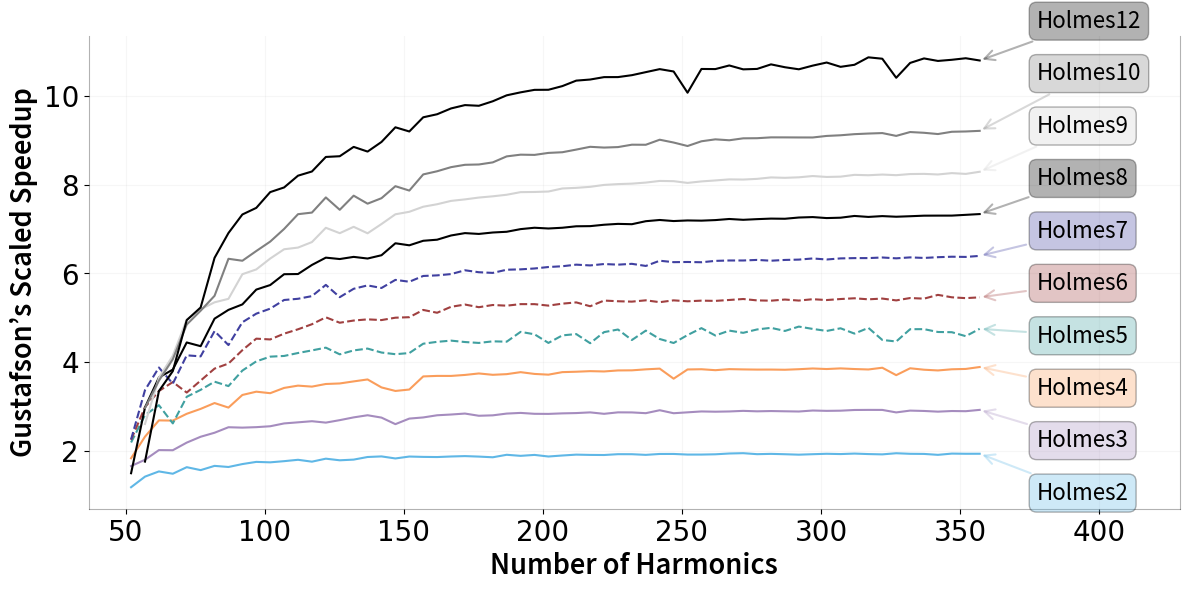

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# Загружаем файл
df = pd.read_csv('proc/benchmark_AMD_Ryzen_5_7600X_6-Core_Processor_12_100.csv')

# Очищаем столбцы
df['TotalTime_ms'] = pd.to_numeric(df['TotalTime_ms'], errors='coerce')
df['Speedup'] = pd.to_numeric(df['Speedup'], errors='coerce')
df['Efficiency'] = pd.to_numeric(df['Efficiency'], errors='coerce')
df['Threads'] = pd.to_numeric(df['Threads'], errors='coerce')

# Вычисляем Overhead, Amdahl’s Fraction, Gustafson’s Scaled Speedup
df['Overhead_ms'] = np.nan
df['Amdahls_Fraction'] = np.nan
df['Gustafsons_Scaled_Speedup'] = np.nan

for idx, row in df.iterrows():
    if row['Algorithm'].startswith('Holmes') and row['Threads'] > 1:
        holmes1_row = df[(df['Algorithm'] == 'Holmes1') & (df['Harmonics'] == row['Harmonics'])]
        if not holmes1_row.empty:
            T_s = holmes1_row['TotalTime_ms'].iloc[0]
            T_p = row['TotalTime_ms']
            p = row['Threads']
            # Overhead
            df.at[idx, 'Overhead_ms'] = T_p  - T_s/p
            # Amdahl’s Fraction и Gustafson’s только для Speedup >= 1
            S_p = row['Speedup']
            if S_p >= 1 and p > 1 and S_p > 0:
                f = (p - S_p) / (S_p * (p - 1))
                if 0 <= f <= 1:
                    df.at[idx, 'Amdahls_Fraction'] = f
                    df.at[idx, 'Gustafsons_Scaled_Speedup'] = f + (1 - f) * p


# Уникальные методы (исключаем Holmes5,7,9,11)
all_methods = df['Algorithm'].unique()
methods = [m for m in all_methods if not (m.startswith('Holmes') and int(m[6:]) >= 10 and int(m[6:]) % 2 == 1)]
speedup_methods = [m for m in methods if m not in ['Belikov', 'Cunningham', 'Holmes1']]

# Назначаем цвета
color_keys = list(colors.keys())
method_colors = {}
for i, method in enumerate(methods):
    color_key = color_keys[i % len(color_keys)]
    method_colors[method] = colors[color_key]
holmes_methods = [m for m in methods if m.startswith('Holmes')]
if holmes_methods:
    max_threads_method = max(holmes_methods, key=lambda m: int(m[6:]))
    method_colors[max_threads_method] = colors['black']

# 1. График TotalTime_ms vs Harmonics (логарифмический масштаб)
fig1, ax1 = plt.subplots(figsize=(12, 6))
grouped_data = {}
for method in methods:
    method_df = df[df['Algorithm'] == method]
    grouped = method_df.groupby('Harmonics')['TotalTime_ms'].mean().reset_index()
    grouped_data[method] = grouped
    if len(grouped) > 0 and not grouped['TotalTime_ms'].isna().all():
        linestyle = '--' if method_colors[method] in [colors[c] for c in dashed_colors] and method != max_threads_method else '-'
        ax1.plot(grouped['Harmonics'], grouped['TotalTime_ms'], 
                 color=method_colors[method], linewidth=1.5, linestyle=linestyle)

style_plot_log(ax1, 'Execution Time, ms')
add_annotations_log(ax1, grouped_data, methods, method_colors, y_col='TotalTime_ms',
                    x_extend=100, text_offset_x=30, log_reserve=4, exp_base=2.2)
plt.tight_layout()
ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1] + 2)
plt.savefig('total_time_vs_harmonics.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. График Speedup vs Harmonics (линейный масштаб)
fig2a, ax2a = plt.subplots(figsize=(12, 6))
grouped_speedup_data = {}
for method in speedup_methods:
    method_df = df[df['Algorithm'] == method]
    grouped = method_df.groupby('Harmonics')['Speedup'].mean().reset_index()
    grouped_speedup_data[method] = grouped
    if len(grouped) > 0 and not grouped['Speedup'].isna().all():
        linestyle = '--' if method_colors[method] in [colors[c] for c in dashed_colors] and method != max_threads_method else '-'
        ax2a.plot(grouped['Harmonics'], grouped['Speedup'], 
                  color=method_colors[method], linewidth=1.5, linestyle=linestyle)

style_plot_linear(ax2a, 'Speedup')
add_annotations_linear(ax2a, grouped_speedup_data, speedup_methods, method_colors, y_col='Speedup',
                       x_extend=70, text_offset_x=20.5, y_extend=0.1)
plt.tight_layout()
ax2a.set_xlim(ax2a.get_xlim()[0], ax2a.get_xlim()[1] + 2)
plt.savefig('speedup_vs_harmonics.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. График Efficiency vs Harmonics (линейный масштаб)
fig2b, ax2b = plt.subplots(figsize=(12, 6))
grouped_efficiency_data = {}
for method in speedup_methods:
    method_df = df[df['Algorithm'] == method]
    grouped = method_df.groupby('Harmonics')['Efficiency'].mean().reset_index()
    grouped_efficiency_data[method] = grouped
    if len(grouped) > 0 and not grouped['Efficiency'].isna().all():
        linestyle = '--' if method_colors[method] in [colors[c] for c in dashed_colors] and method != max_threads_method else '-'
        ax2b.plot(grouped['Harmonics'], grouped['Efficiency'], 
                  color=method_colors[method], linewidth=1.5, linestyle=linestyle)

style_plot_linear(ax2b, 'Efficiency')
add_annotations_linear(ax2b, grouped_efficiency_data, speedup_methods, method_colors, y_col='Efficiency',
                       x_extend=70, text_offset_x=20.5, y_extend=0.3)
plt.tight_layout()
ax2b.set_xlim(ax2b.get_xlim()[0], ax2b.get_xlim()[1] + 2)
plt.savefig('efficiency_vs_harmonics.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. График Overhead vs Harmonics (линейный масштаб)
fig3, ax3 = plt.subplots(figsize=(12, 6))
grouped_overhead_data = {}
for method in speedup_methods:
    method_df = df[df['Algorithm'] == method]
    grouped = method_df.groupby('Harmonics')['Overhead_ms'].mean().reset_index()
    grouped_overhead_data[method] = grouped
    if len(grouped) > 0 and not grouped['Overhead_ms'].isna().all():
        linestyle = '--' if method_colors[method] in [colors[c] for c in dashed_colors] and method != max_threads_method else '-'
        ax3.plot(grouped['Harmonics'], grouped['Overhead_ms'], 
                 color=method_colors[method], linewidth=1.5, linestyle=linestyle)

style_plot_linear(ax3, 'Overhead, ms', xlabel='Number of Harmonics')
add_annotations_linear(ax3, grouped_overhead_data, speedup_methods, method_colors, y_col='Overhead_ms', x_col='Harmonics',
                       x_extend=100, text_offset_x=30, y_extend=0.1)
plt.tight_layout()
ax3.set_xlim(ax3.get_xlim()[0], ax3.get_xlim()[1] + 2)
plt.savefig('overhead_vs_harmonics.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. График Amdahl’s Fraction vs Harmonics (линейный масштаб, только для Harmonics >= 50)
fig4, ax4 = plt.subplots(figsize=(12, 6))
grouped_amdahl_data = {}
for method in speedup_methods:
    method_df = df[(df['Algorithm'] == method) & (df['Harmonics'] >= 50)]
    grouped = method_df.groupby('Harmonics')['Amdahls_Fraction'].mean().reset_index()
    grouped_amdahl_data[method] = grouped
    if len(grouped) > 0 and not grouped['Amdahls_Fraction'].isna().all():
        linestyle = '--' if method_colors[method] in [colors[c] for c in dashed_colors] and method != max_threads_method else '-'
        ax4.plot(grouped['Harmonics'], grouped['Amdahls_Fraction'], 
                 color=method_colors[method], linewidth=1.5, linestyle=linestyle)

style_plot_linear(ax4, 'Amdahl’s Fraction')
add_annotations_linear(ax4, grouped_amdahl_data, speedup_methods, method_colors, y_col='Amdahls_Fraction',
                       x_extend=70, text_offset_x=20.5, y_extend=0.1)
plt.tight_layout()
ax4.set_xlim(ax4.get_xlim()[0], ax4.get_xlim()[1] + 2)
plt.savefig('amdahls_fraction_vs_harmonics.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. График Gustafson’s Scaled Speedup vs Harmonics (линейный масштаб, только для Harmonics >= 50)
fig5, ax5 = plt.subplots(figsize=(12, 6))
grouped_gustafson_data = {}
for method in speedup_methods:
    method_df = df[(df['Algorithm'] == method) & (df['Harmonics'] >= 50)]
    grouped = method_df.groupby('Harmonics')['Gustafsons_Scaled_Speedup'].mean().reset_index()
    grouped_gustafson_data[method] = grouped
    if len(grouped) > 0 and not grouped['Gustafsons_Scaled_Speedup'].isna().all():
        linestyle = '--' if method_colors[method] in [colors[c] for c in dashed_colors] and method != max_threads_method else '-'
        ax5.plot(grouped['Harmonics'], grouped['Gustafsons_Scaled_Speedup'], 
                 color=method_colors[method], linewidth=1.5, linestyle=linestyle)

style_plot_linear(ax5, 'Gustafson’s Scaled Speedup')
add_annotations_linear(ax5, grouped_gustafson_data, speedup_methods, method_colors, y_col='Gustafsons_Scaled_Speedup',
                       x_extend=70, text_offset_x=20.5, y_extend=0.1)
plt.tight_layout()
ax5.set_xlim(ax5.get_xlim()[0], ax5.get_xlim()[1] + 2)
plt.savefig('gustafsons_scaled_speedup_vs_harmonics.png', dpi=300, bbox_inches='tight')
plt.show()